In [23]:
import numpy as np
import random
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from scipy.stats import linregress
import pandas as pd

In [9]:
def generate_ground_state_set_GHZ(max_hd, degeneracy):
    """Generate a set of ground states with a guaranteed max_hd and at least one GHZ pairing (0 and max_hd)"""
    gs_set = {0, (2**max_hd) - 1}
    while len(gs_set) < degeneracy:
        gs_set.add(random.getrandbits(max_hd))
    return list(gs_set)

def generate_ground_state_set_random(max_hd, degeneracy, N):
    """Generate a set of ground states with specified degeneracy."""
    gs_set = {0}
    
    # Generate the first state by flipping the first max_hd bits
    next_gs = 0
    for i in range(max_hd):
        next_gs ^= (1 << i)  # Flip the ith bit
    gs_set.add(next_gs)
    last_gs = next_gs

    # Generate the remaining states
    while len(gs_set) < degeneracy:
        next_gs = last_gs
        for _ in range(max_hd):
            i = random.randint(0, N - 1)
            next_gs ^= (1 << i)  # Flip the ith bit
        gs_set.add(next_gs)
        last_gs = next_gs

    return list(gs_set)

def calculate_hamming_distances(gs_array):
    """Calculate Hamming distances and spins involved from the ground state array."""
    hd_list = []
    spins_involved = 0
    degeneracy = len(gs_array)

    for gs_i in range(degeneracy):
        for gs_j in range(gs_i + 1, degeneracy):
            binary_diff = gs_array[gs_i] ^ gs_array[gs_j]
            hd_list.append(binary_diff.bit_count())
            spins_involved |= binary_diff

    return hd_list, spins_involved

def compute_overlap_distribution(hd_list, N, degeneracy):
    """Compute the overlap distribution and related statistics."""
    overlap_dist = np.zeros(N + 1)
    overlap_dist[-1] = 1 / degeneracy

    for hd in hd_list:
        overlap_dist[-hd - 1] += 2 / (degeneracy**2)

    od_bins = np.array([((2 * i) / N) - 1 for i in range(N + 1)])
    od_mean = np.sum(od_bins * overlap_dist)
    od_var = np.sum(overlap_dist * (od_bins - od_mean) ** 2)

    return overlap_dist, od_mean, od_var

In [13]:
N = 100
num_samples = 100
degen_range = [2, 15]
data_list_ghz = []

for degeneracy in range(degen_range[0], degen_range[1]):
    for max_hd in range(int(np.ceil(np.log2(degeneracy))), N + 1):
        for _ in range(num_samples):
            # Generate ground state set
            gs_array = generate_ground_state_set_GHZ(max_hd, degeneracy)

            # Calculate Hamming distances and spins involved
            hd_list, spins_involved = calculate_hamming_distances(gs_array)

            # Compute overlap distribution and statistics
            _, _, od_var = compute_overlap_distribution(hd_list, N, degeneracy)

            # Append results to the data list
            data_list_ghz.append([spins_involved.bit_count(), od_var, degeneracy])


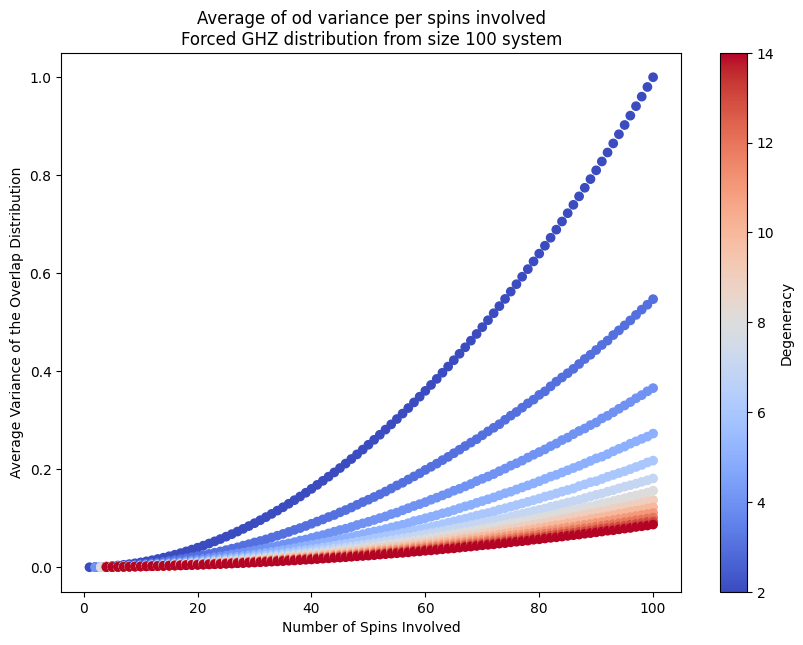

In [32]:
df = pd.DataFrame(data_list_ghz, columns=['si', 'odv', 'deg'])
plot_df = df.groupby(['si','deg'])['odv'].mean().reset_index()


cmap = plt.cm.coolwarm
norm = Normalize(vmin=degen_range[0], vmax=degen_range[1] - 1)
plt.figure(figsize=(10,7))
plt.scatter(x=plot_df['si'], y=plot_df['odv'], c=plot_df["deg"], cmap=cmap, norm=norm)
plt.xlabel("Number of Spins Involved")
plt.ylabel("Average Variance of the Overlap Distribution")
plt.title(f"Average of od variance per spins involved\nForced GHZ distribution from size {N} system")
plt.colorbar(label='Degeneracy')
plt.show()

/var/folders/84/h0vjvdyd5jsfdwfh08421q980000gn/T/ipykernel_64072/2894470188.py:8: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  result = df.groupby('deg').apply(lambda g: power_law_exp(g))


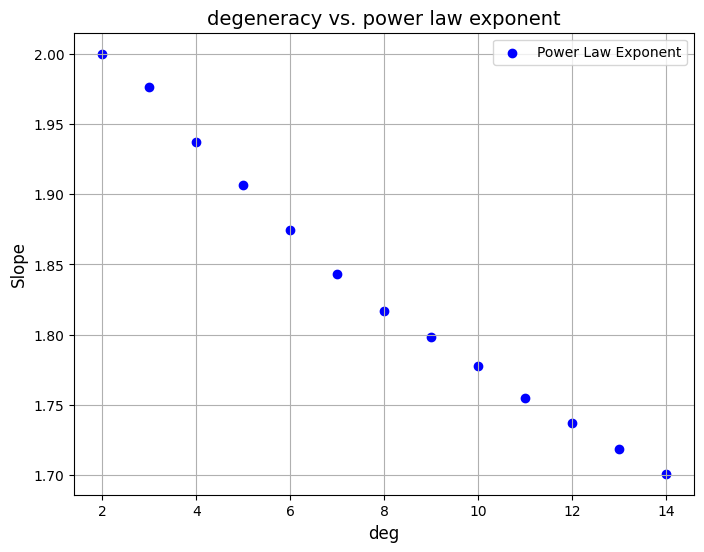

In [33]:
def power_law_exp(group):
    log_x = np.log(group['si'])
    log_y = np.log(group['odv'])
    slope, _, _, _, _ = linregress(log_x, log_y)
    return slope

# Group by 'deg' and apply the custom aggregation function to groups of 'si' and 'odv'
result = df.groupby('deg').apply(lambda g: power_law_exp(g))

# Plot 'deg' vs. power law expoonent
plt.figure(figsize=(8, 6))
plt.scatter(result.index, result.values, marker='o', color='b', label='Power Law Exponent')
plt.xlabel('deg', fontsize=12)
plt.ylabel('Slope', fontsize=12)
plt.title('degeneracy vs. power law exponent', fontsize=14)
plt.grid(True)
plt.legend()
plt.show()


y = ax^n


Text(0, 0.5, 'OD varaince')

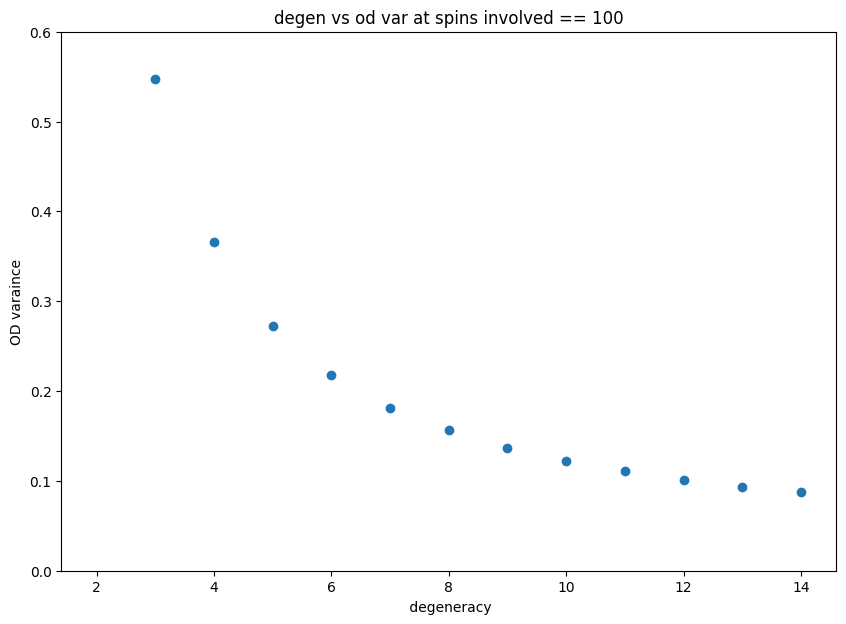

In [35]:
plot_df_1 = df.loc[df["si"] == 100].groupby(['si','deg'])['odv'].mean().reset_index()

plt.figure(figsize=(10,7))
plt.scatter(x=plot_df_1['deg'], y =plot_df_1['odv'])
plt.ylim(0,0.6)
# plt.xscale("log")
plt.title("degen vs od var at spins involved == 100")
plt.xlabel(" degeneracy")
plt.ylabel("OD varaince")
